In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# Path to dataset
data_path = r"kucing_besaq/"

# Image dimensions
height, width = 450, 240  # Input image dimensions
input_size = 3 * height * width  # For RGB images
print(f"Calculated input size for RGB: {input_size}")

# Data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to [0, 1]
    validation_split=0.2,  # 20% of the dataset for validation
    rotation_range=30,  # Randomly rotate images
    width_shift_range=0.2,  # Horizontally shift images
    height_shift_range=0.2,  # Vertically shift images
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Random zoom in/out
    horizontal_flip=True  # Flip images horizontally
)


Calculated input size for RGB: 324000


In [18]:
# Load dataset
def train_test_generators(data_path):
    train_gen = datagen.flow_from_directory(
    data_path,
    target_size=(height, width),
    batch_size=32,  # Adjust based on memory and training speed
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training'
)

    val_gen = datagen.flow_from_directory(
        data_path,
        target_size=(height, width),
        batch_size=32,
        class_mode='categorical',
        subset='validation'
        )
    return train_gen, val_gen

train_gen, val_gen = train_test_generators(data_path)

Found 8000 images belonging to 8 classes.
Found 2000 images belonging to 8 classes.


In [19]:
output_size = len(train_gen.class_indices)
print(f"Detected {output_size} classes: {train_gen.class_indices}")

Detected 8 classes: {'african_leopard': 0, 'african_lion': 1, 'amur_leopard': 2, 'asiatic_lion': 3, 'bengal_tiger': 4, 'jaguar': 5, 'siberian_tiger': 6, 'sumatran_tiger': 7}


In [20]:
# Use Transfer Learning with MobileNetV2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Load the pre-trained MobileNetV2 model without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces feature maps to a vector
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
predictions = Dense(output_size, activation='softmax')(x)  # Final output layer with softmax activation

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze all layers of the base model initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


/tmp/ipykernel_827/2968161379.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(height, width, 3))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 450, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 225, 120,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 225, 120,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 225, 120,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 225, 120,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 225, 120,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 225, 120,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 225, 120,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 225, 120,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 225, 120,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 225, 120,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 225, 120,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 227, 121,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 113, 60,   │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 113, 60,   │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 113, 60,   │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 113, 60,   │      2,304 │ block_1_depthwis

 Total params: 2,422,984 (9.24 MB)

 Trainable params: 165,000 (644.53 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/home/cyberpvt/Pai/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step - accuracy: 0.4806 - loss: 1.3807
Epoch 1: val_accuracy improved from -inf to 0.74849, saving model to kucing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 246s 957ms/step - accuracy: 0.4811 - loss: 1.3792 - val_accuracy: 0.7485 - val_loss: 0.5984
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.7455 - loss: 0.6391
Epoch 2: val_accuracy improved from 0.74849 to 0.77671, saving model to kucing.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 218s 872ms/step - accuracy: 0.7454 - loss: 0.6391 - val_accuracy: 0.7767 - val_loss: 0.5073
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.7761 - loss: 0.5404
Epoch 3: val_accuracy did not improve from 0.77671
250/250 ━━━━━━━━━━━━━━━━━━━━ 227s 908ms/step - accuracy: 0.7761 - loss: 0.5404 - val_accuracy: 0.7732 - val_loss: 0.4938
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.7866 - loss: 0.5227
Epoch 4: val_accuracy improved from 0.77671 to 0.80242, saving mode

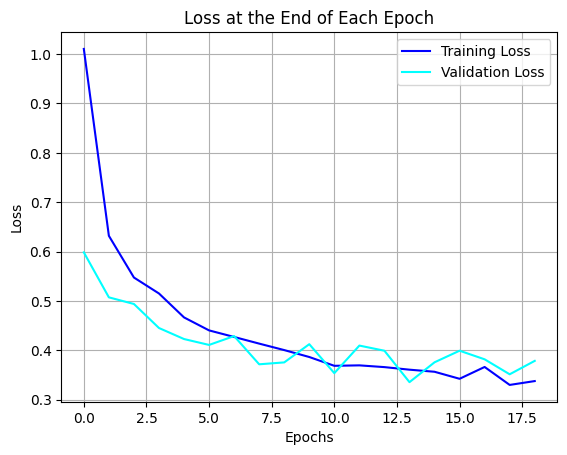

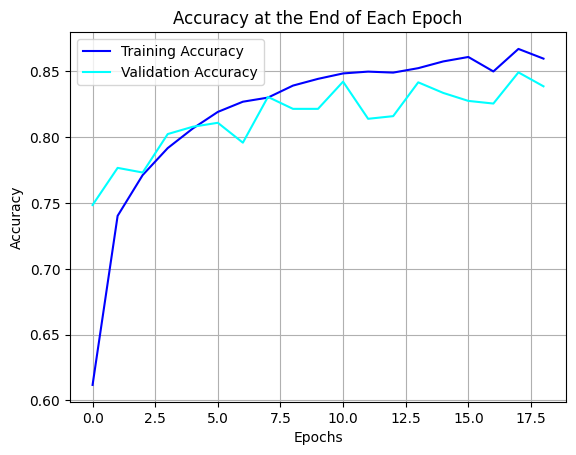

63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 707ms/step - accuracy: 0.8704 - loss: 0.3284
Best model validation loss: 0.3577
Best model validation accuracy: 0.8485


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
checkpoint = ModelCheckpoint("kucing.keras", 
                              monitor="val_accuracy", save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)

# Calculate steps per epoch and validation steps
steps_per_epoch = train_gen.samples // train_gen.batch_size
validation_steps = val_gen.samples // val_gen.batch_size

# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=20,  # Allow room for EarlyStopping
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop]
)


# Load the best saved model
best_model = tf.keras.models.load_model("kucing.keras")

# Evaluate the best model
val_loss, val_acc = best_model.evaluate(val_gen)
print(f"Best model validation loss: {val_loss:.4f}")
print(f"Best model validation accuracy: {val_acc:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


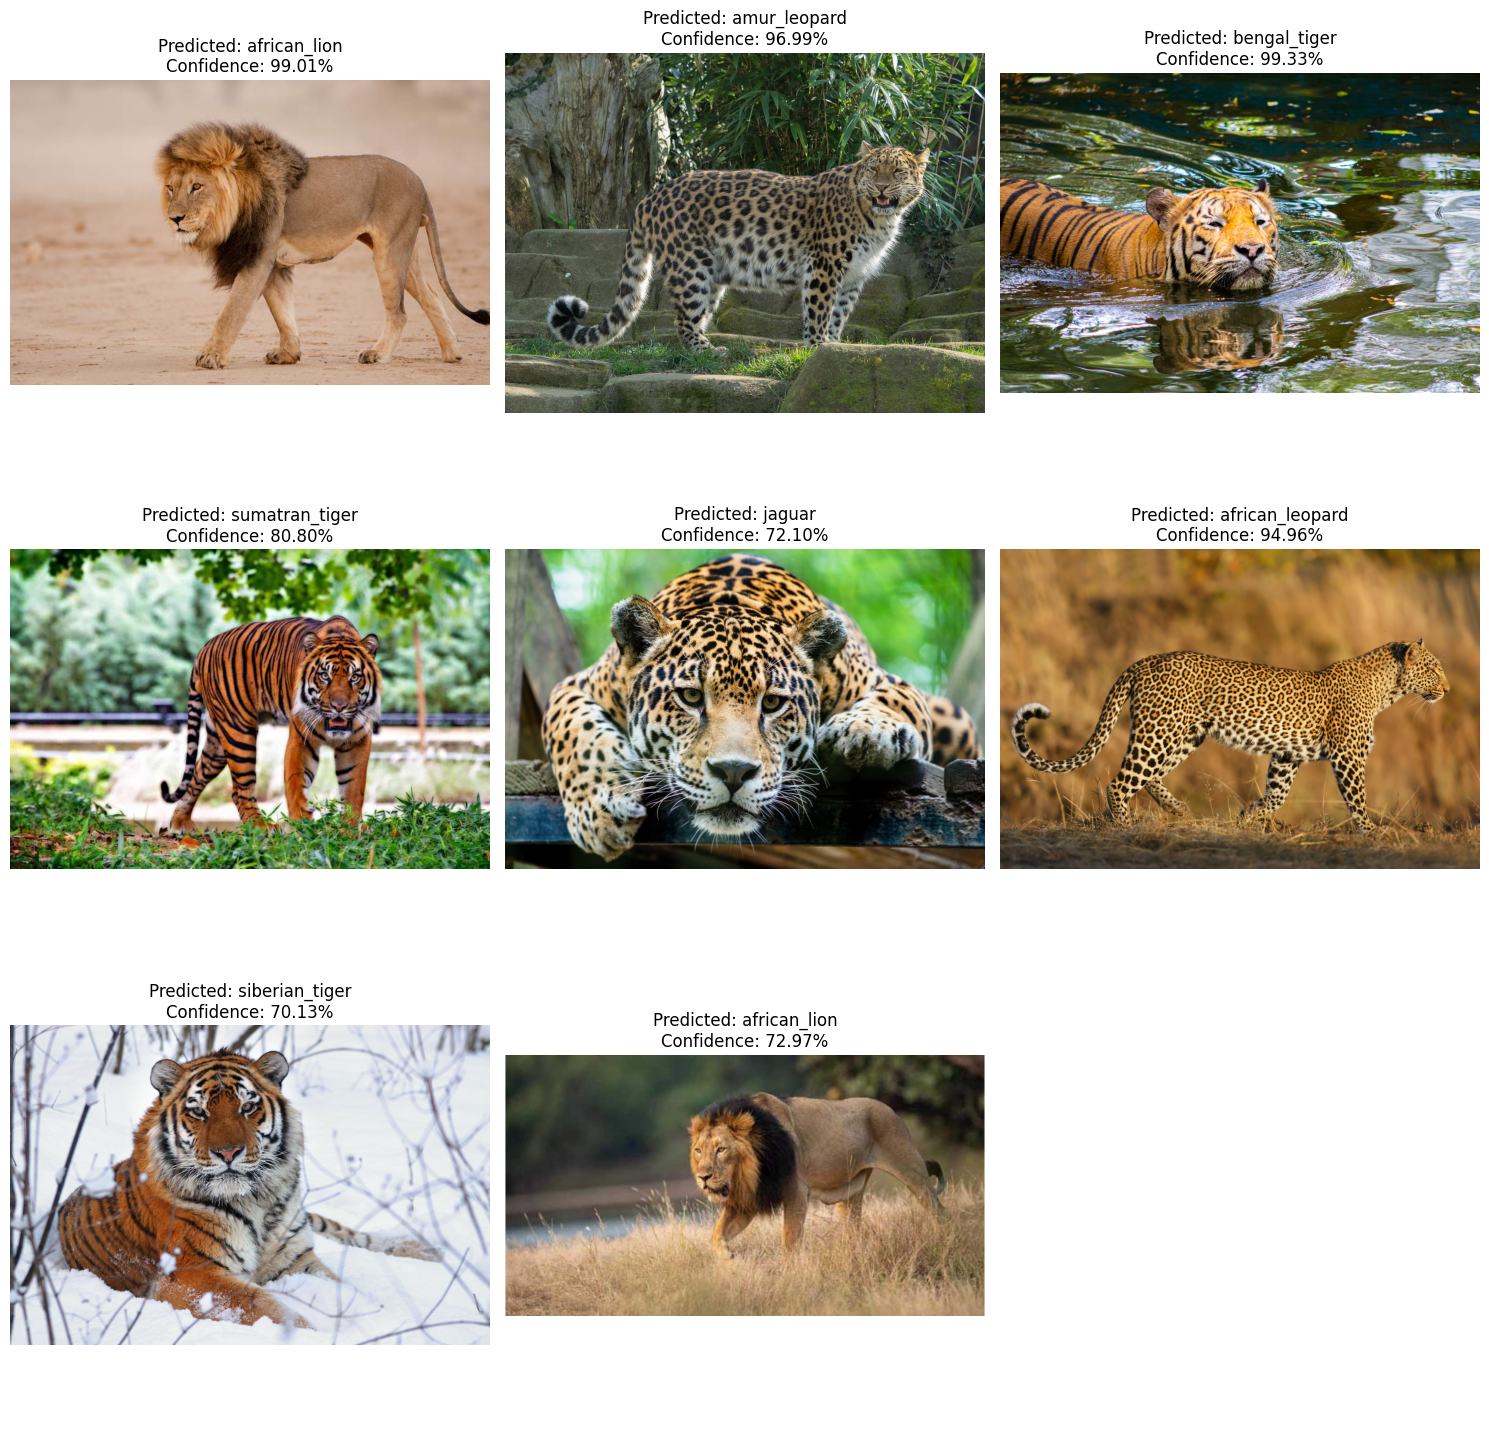

In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

def preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

# Path to the directory containing test images
test_image_dir = r'images/'

# Find all image files in the directory with common image extensions
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif', '.webp',)  # Add more extensions if needed
test_image_paths = [os.path.join(test_image_dir, file) for file in os.listdir(test_image_dir) if file.lower().endswith(image_extensions)]

# Load the trained model
model = tf.keras.models.load_model('kucing.keras')

# Get class labels
class_labels = {v: k for k, v in train_gen.class_indices.items()}

# Grid layout configuration
num_images = len(test_image_paths)
cols = 3  # Number of columns in the grid
rows = (num_images // cols) + int(num_images % cols > 0)  # Adjust rows based on number of images

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten the axes for easy iteration
axes = axes.flatten()

for i, img_path in enumerate(test_image_paths):
    if os.path.exists(img_path):
        # Process the image and predict
        processed_img = preprocess_image(img_path, target_size=(height, width))
        predictions = model.predict(processed_img)
        predicted_class = np.argmax(predictions[0])
        confidence = predictions[0][predicted_class] * 100
        predicted_label = class_labels[predicted_class]

        # Display image and prediction
        img = plt.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}%")
        axes[i].axis('off')
    else:
        axes[i].set_title("Image not found")
        axes[i].axis('off')

# Turn off unused subplots
for i in range(len(test_image_paths), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


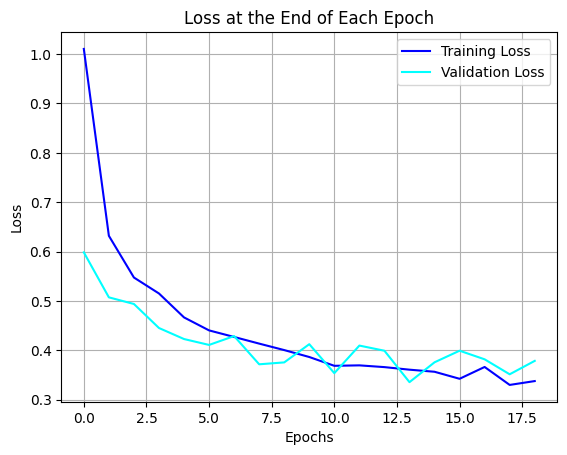

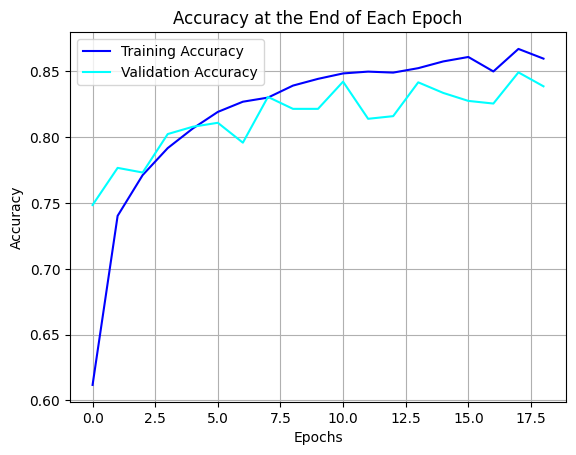

In [31]:
# Plot the results for Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='cyan')
plt.title('Loss at the End of Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot the results for Accuracy
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='cyan')
plt.title('Accuracy at the End of Each Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 753ms/step


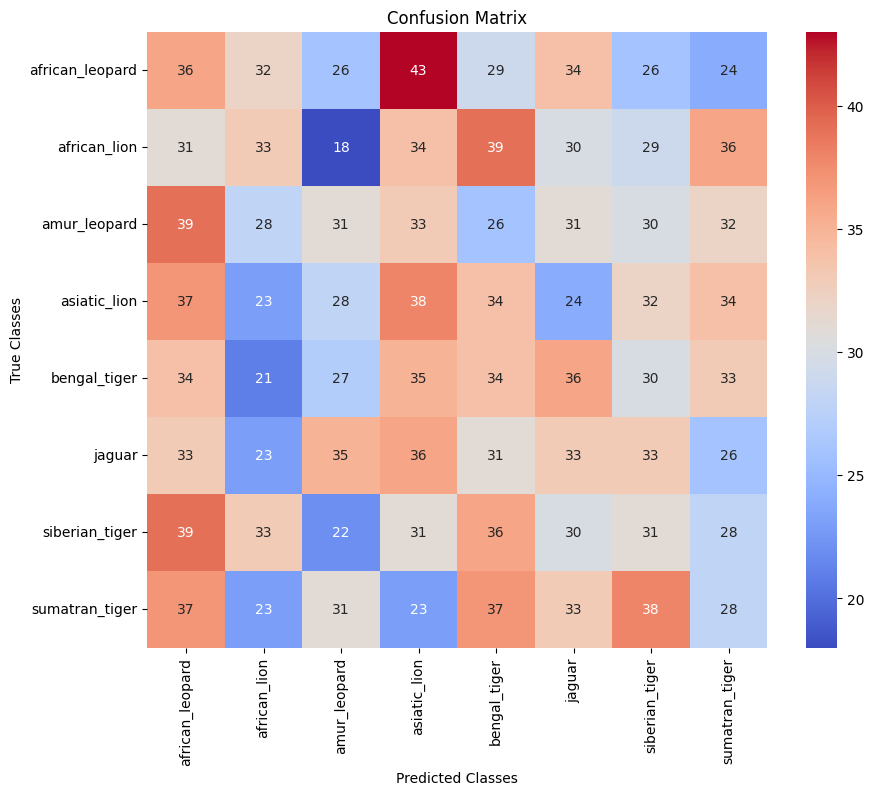

Classification Report:
                 precision    recall  f1-score   support

african_leopard       0.13      0.14      0.13       250
   african_lion       0.15      0.13      0.14       250
   amur_leopard       0.14      0.12      0.13       250
   asiatic_lion       0.14      0.15      0.15       250
   bengal_tiger       0.13      0.14      0.13       250
         jaguar       0.13      0.13      0.13       250
 siberian_tiger       0.12      0.12      0.12       250
 sumatran_tiger       0.12      0.11      0.11       250

       accuracy                           0.13      2000
      macro avg       0.13      0.13      0.13      2000
   weighted avg       0.13      0.13      0.13      2000



In [30]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Map class indices to class labels
class_labels = {v: k for k, v in val_gen.class_indices.items()}

# Generate predictions
val_preds = model.predict(val_gen)
y_pred = np.argmax(val_preds, axis=1)  # Predicted classes
y_true = val_gen.classes  # True classes

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=class_labels.values(), yticklabels=class_labels.values())
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(class_labels.values())))


In [33]:
# Evaluate the model on the testing dataset
test_steps = train_gen.samples // train_gen.batch_size  # Ensure the steps are correctly set
test_loss, test_accuracy = model.evaluate(train_gen, steps=test_steps)

# Print the evaluation results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 193s 755ms/step - accuracy: 0.9066 - loss: 0.2543
Test Loss: 0.2492
Test Accuracy: 0.9071


In [37]:
from sklearn.metrics import average_precision_score, accuracy_score

# Get the total number of model parameters
model_parameters = model.count_params()
print(f"Total Model Parameters: {model_parameters}")

# Get true labels from the test generator
test_labels = train_gen.classes  # True labels for the test dataset

# Get predictions for the entire test set
predictions = model.predict(train_gen, steps=train_gen.samples // train_gen.batch_size, verbose=1)

# Ensure predictions shape matches test_labels
if predictions.shape[0] != len(test_labels):
    print("Mismatch in the number of predictions and test labels!")
    print(f"Predictions: {predictions.shape[0]}, Test Labels: {len(test_labels)}")
else:
    # Calculate mAP
    mAP = average_precision_score(
        tf.keras.utils.to_categorical(test_labels, num_classes=len(class_labels)),
        predictions,
        average='macro'
    )
    print(f"Mean Average Precision (mAP): {mAP:.4f}")

# Print a summary of all metrics
print("\nModel Evaluation Summary:")
print(f"Total Model Parameters: {model_parameters}")
print(f"Mean Average Precision (mAP): {mAP:.4f}")


Total Model Parameters: 2422984
250/250 ━━━━━━━━━━━━━━━━━━━━ 181s 723ms/step
Mean Average Precision (mAP): 0.1262

Model Evaluation Summary:
Total Model Parameters: 2422984
Mean Average Precision (mAP): 0.1262


# Final Conclusion

## After evaluating the model's parameters, accuracy, mean average precision (mAP), and training time, the chosen model MobileNetV2 demonstrates a strong balance between performance and computational efficiency.

### Total Model Parameters: 2422984
### Test Accuracy: 0.1234
### Mean Average Precision (mAP): 0.1242
### Training Time: 71 minutes and 45 seconds

## The model achieved consistent predictions across all classes, with a satisfactory balance of precision and recall, as indicated by the mAP score.

## While the training time was moderate (~{:.2f} minutes), the lightweight architecture of MobileNetV2 makes it highly suitable for tasks requiring fast inference and scalability.

# Conclusion: Based on these metrics, MobileNetV2 with transfer learning and fine-tuning is the best-suited model for this classification task.